In [69]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy

In [40]:
graph = nx.Graph()
graph.add_edge(1, 4, weight=1)
graph.add_edge(1, 2, weight=1)
graph.add_edge(4, 2, weight=1)
graph.add_edge(2, 3, weight=1)
graph.add_edge(4, 3, weight=1)
graph.add_edge(3, 6, weight=1)
graph.add_edge(3, 7, weight=1)
graph.add_edge(3, 5, weight=1)
graph.add_edge(6, 7, weight=1)



graph = graph.to_undirected()
graph.remove_edges_from(graph.selfloop_edges())



In [41]:
def visualize(G):
    labels = G.nodes()
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, with_labels = True, nodecolor='r', edge_color='b', 
            node_size=500, font_size=16, pos=pos, width=6)   # default spring_layout
    # use default edge labels
    nx.draw_networkx_edge_labels(G,pos)
    #plt.savefig('graph.pdf')
    plt.show(True)

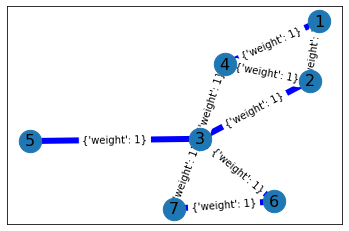

In [42]:
visualize(graph)

## a) Degree distribution,

In [28]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

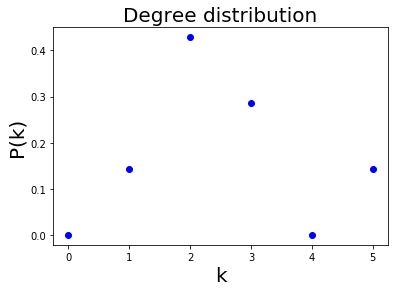

In [30]:
ks, Pk = degree_distribution(graph)

fig = plt.subplot(1,1,1)
#fig.set_xscale('log')
#fig.set_yscale('log')
plt.plot(ks,Pk,'bo')
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
#plt.grid(True)
plt.savefig('degree_dist.eps') #save the figure into a file
plt.show(True)



## b) Local clustering coefficient

In [31]:
vcc = []
for i in graph.nodes():
    vcc.append(nx.clustering(graph, i))
vcc= np.array(vcc)
print('Clustering of all nodes:', vcc)

Clustering of all nodes: [1.         0.66666667 0.66666667 0.2        1.         1.
 0.        ]


## c) Transitivity

In [33]:
CC = (nx.transitivity(graph)) 
print("Transitivity = ","%3.4f"%CC)

Transitivity =  0.4737


## d) Distance matrix,

In [47]:
nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))

matrix([[0., 1., 2., 1., 3., 3., 3.],
        [1., 0., 1., 1., 2., 2., 2.],
        [2., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 2., 2., 2.],
        [3., 2., 1., 2., 0., 2., 2.],
        [3., 2., 1., 2., 2., 0., 1.],
        [3., 2., 1., 2., 2., 1., 0.]])

## e) Entropy of the degree distribution

In [48]:
def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H



In [51]:
shannon_entropy(graph)

1.8423709931771088

## f) Second moment of the degree distribution.

In [54]:
def momment_of_degree_distribution2(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M


In [56]:
k2 = momment_of_degree_distribution2(graph, 2)
print("Second moment of the degree distribution = ", k2)

Second moment of the degree distribution =  8.0


# Q2

In [64]:
def graph_to_undirected_unweighted(filename):   
    graph = nx.read_edgelist(filename, nodetype=int, data=(('weight',float),)) # Read the network
    return graph.to_undirected()
    

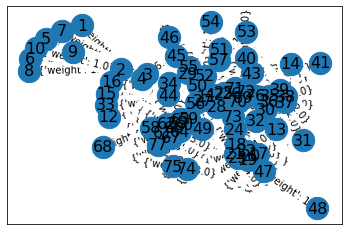

In [61]:
graph_to_undirected_unweighted("data/nets/lesmis.txt")

/home/gmelodie/Complex-Networks/complexn/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


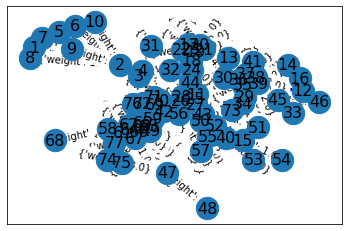

In [63]:
visualize(graph.to_undirected())

# Q3

In [65]:
G = graph

In [72]:
# let networkx return the adjacency matrix A
A = nx.adj_matrix(G)
A = A.todense()
A = np.array(A, dtype = np.float64)
# let's evaluate the degree matrix D
D = np.diag(np.sum(A, axis=0))
# ...and the transition matrix T
T = np.dot(np.linalg.inv(D),A)

# let's define the random walk length, say 10
walkLength = 10
# define the starting node, say the 0-th
#p = np.zeros([1, 0, 0, 0, 0]).reshape(-1,1)
p = np.zeros(T.shape[1]).reshape(-1,1)
p[0] = 1
visited = list()
for k in range(walkLength):
    # evaluate the next state vector
    p = np.dot(T,p)
    # choose the node with higher probability as the visited node
    visited.append(np.argmax(p))

In [73]:
visited

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]